## Max Wienandts

Problem Statement:
-  Is BERT and DistilBERT appropriate to sentiment analysis? Is Latent Dirichlet Allocation (LDA) appropriate for topic modeling?

|SUMMARY|
|:------------------------------------------------|
|[**1.Verify missing values**](#Verify_missing_values)|
|[**2. Exploratory data analysis**](#Exploratory_data_analysis)
|[**3. Wordcloud**](#Wordcloud)|

This project have 4 Jupyter notebook:
- 1 ETL and EDA.ipynb;
- 2 LSTM BERT DistilBERT.ipynb;
- 3 Topic modeling.ipynb; and
- 4 Production.ipynb.

They should be runned in order. \
The objective of the first notebook is to known better our dataset and to clean it. \
The second notebook have the models related to sentiment analysis. \
The third one have the topic modeling. \
Finally, the last notebook is an example to how to apply the sentiment and topic models to an dataset and to a custom review.

Moreover, there is a report "Sentiment Analysis and Topic Modeling - Max Wienandts.pdf" where can be found the sections:
* Problem statement
* Introduction
* The dataset
* Models
  * Long Short-Term Memory (LSTM)
  * Bidirectional Encoder Representations from Transformers (BERT)
  * DistilBERT (a distilled version of BERT)
  * Latent Dirichlet Allocation (LDA)
* Results
  * Long Short-Term Memory (LSTM)
  * Bidirectional Encoder Representations from Transformers (BERT)
  * DistilBERT (a distilled version of BERT)
  * Comparison among the three models
  * Latent Dirichlet Allocation (LDA)
* Conclusion
* References

Also, there a PowerPoint "Sentiment Analysis and Topic Modeling - Max Wienandts.pptx", and a Youtube presentation https://youtu.be/a0wW95m3q5w.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk   # It is necessary to have to download 'stopwords' from nltk.

from sklearn import preprocessing

In [ ]:
# Select if using sample or not
path_full_table = 'glassdoor_reviews.csv'
path_sample = 'df_sample.csv'
csv_path = path_sample

In [2]:
# Read table. Downloaded from https://www.kaggle.com/datasets/davidgauthier/glassdoor-job-reviews?sort=most-comments.
df = pd.read_csv(path_sample, usecols = ['firm', 'pros', 'cons'])
# Creates small sample.
df.sample(frac = 0.05, random_state = 1).reset_index(drop = True).to_csv('df_sample.csv', index = False)

# Rename columns so pros = 1, cons = 0
df.columns = ['firm', '1', '0']
print('Observations:', len(df))
df.head(10)

Observations: 838566


,firm,1,0
0,AFH-Wealth-Management,Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication."
1,AFH-Wealth-Management,"Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...
2,AFH-Wealth-Management,Easy to get the job even without experience in...,"Very low salary, poor working conditions, very..."
3,AFH-Wealth-Management,Nice staff to work with,No career progression and salary is poor
4,AFH-Wealth-Management,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr..."
5,AFH-Wealth-Management,Some good people to work with.\n\nFlexible wor...,Morale.\n\nLack of managerial structure.\n\nDo...
6,AFH-Wealth-Management,Good investment management strategy. Overall t...,The management and seniors are ruthless. No tr...
7,AFH-Wealth-Management,The people are great and the culture is very f...,Wouldn't necessarily say there are any cons to...
8,AFH-Wealth-Management,"Nice Staff, good HR Team.\r\nFeels vibrant and...",Can't really think of any obvious cons
9,AFH-Wealth-Management,Made some life time friends.,Was let go from the company just before Christ...


In [3]:
# Put the reviews in only one column and create a target column expressing if the review is positive or negative.
df = pd.melt(df, id_vars=['firm'], value_vars=['1', '0'])
print('Observations after melt:', len(df))
df.columns = ['firm', 'target', 'review']
df = df[['firm', 'review', 'target']]

# Shuffle the data.
df = df.sample(frac = 1, random_state = 1).reset_index(drop = True)

display(df.head(5))
display(df.tail(5))

Observations after melt: 1677132


,firm,review,target
0,IBM,I can not think of any,0
1,Holiday-Inn,little advancement\r\nbased on owners\r\nprett...,0
2,Barclays,Low career advancement opportunity and politics,0
3,KPMG,The peolpe. Everone that I worked with was fr...,1
4,McDonald-s,Dealing with angry customers and putting up wi...,0


,firm,review,target
1677127,next,Flexible when you have a young family,1
1677128,Marriott-International,Great benefits. Ability to transfer to any job...,1
1677129,Kier-Group,Some really great employees throughout the bus...,1
1677130,Marriott-International,So many opportunities to work for a world clas...,1
1677131,CBRE,Good company culture in place,1


<div id='Verify_missing_values' />
    
## Verify missing values

In [4]:
df.isna().sum()

firm       0
review    15
target     0
dtype: int64

In [5]:
# Considering that there are only 15 missing values in a dataframe with 1,677,132 observations, I will delete these observations.
df = df.dropna()
df.head(10)

,firm,review,target
0,IBM,I can not think of any,0
1,Holiday-Inn,little advancement\r\nbased on owners\r\nprett...,0
2,Barclays,Low career advancement opportunity and politics,0
3,KPMG,The peolpe. Everone that I worked with was fr...,1
4,McDonald-s,Dealing with angry customers and putting up wi...,0
5,Microsoft,"Great culture, great benefits, good salary",1
6,The-British-Army,"Plenty of leave, free fitness",1
7,Tesco,Friendly work environment and can fit alongsid...,1
8,Microsoft,"Excellent benefits, stock purchase options, co...",1
9,Whitbread,Good company to work for,1


<div id='Exploratory_data_analysis' />
    
## Exploratory data analysis

In [6]:
# Before doing any study in our data, lets anonymize the company names.
label_acoder = preprocessing.LabelEncoder()
label_acoder.fit(df.firm)
df.firm = label_acoder.transform(df.firm)
df.head(10)

,firm,review,target
0,179,I can not think of any,0
1,174,little advancement\r\nbased on owners\r\nprett...,0
2,47,Low career advancement opportunity and politics,0
3,199,The peolpe. Everone that I worked with was fr...,1
4,229,Dealing with angry customers and putting up wi...,0
5,236,"Great culture, great benefits, good salary",1
6,343,"Plenty of leave, free fitness",1
7,341,Friendly work environment and can fit alongsid...,1
8,236,"Excellent benefits, stock purchase options, co...",1
9,414,Good company to work for,1


Biggest review: 3172
Smallest review: 1

Describe for reviews' length:


,n_words
count,1.677117e+06
mean,1.858121e+01
std,3.282361e+01
min,1.000000e+00
25%,6.000000e+00
50%,9.000000e+00
75%,2.000000e+01
90%,3.700000e+01
95%,5.700000e+01
99%,1.420000e+02


,count,proportion
target,,
1,838564,0.500003
0,838553,0.499997


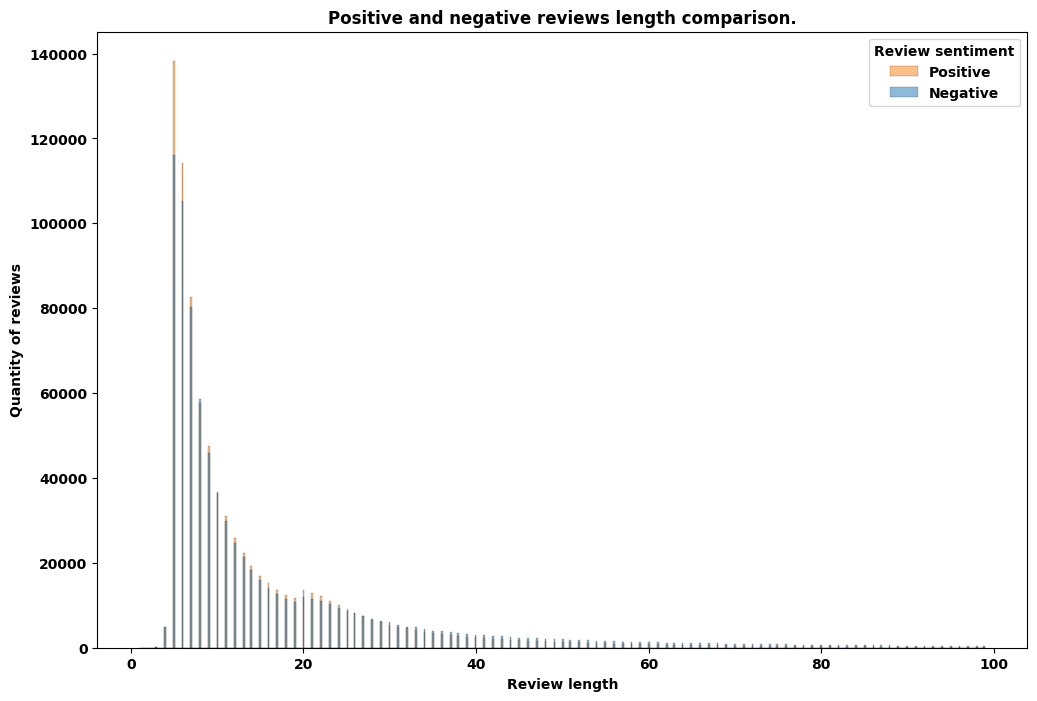

In [7]:
# Substitute /r and /n by space
df.replace({ '\r': ' ', '\n' : ' '}, regex = True, inplace = True)

# Count how many words the reviews have.
df['n_words'] = df['review'].str.count(' ') + 1
print(f'Biggest review: {df.n_words.max()}')
print(f'Smallest review: {df.n_words.min()}')

# Describe for reviews' length
print()
print("Describe for reviews' length:")
display(df[['n_words']].describe(percentiles = [.25, .50, .75, .90, .95, .99])) 

# Proportion of positive and negative reviews.
print()
df_target = pd.DataFrame(df.target.value_counts(), columns = ['count'])
df_target['proportion'] = df_target['count'] / df_target['count'].sum()
display(df_target)
print()

# Plot the quantity of words for positive and negative reviews.
fig=plt.figure(figsize=(12,8))
df_plot = df[df.n_words < 100].copy()
sns.histplot(x = df_plot['n_words'], hue = df_plot['target'])
plt.legend(title = 'Review sentiment', labels = ['Positive', 'Negative'])
plt.title('Positive and negative reviews length comparison.')
plt.xlabel('Review length')
plt.ylabel('Quantity of reviews')
plt.show()
plt.close()

In [8]:
# Sanity check to verify if the legend is correct
print(f'Positive reviews with 5 words: {len(df[np.in1d(df.target, "1") & np.in1d(df.n_words, 5)])}')
print(f'Negative reviews with 5 words: {len(df[np.in1d(df.target, "0") & np.in1d(df.n_words, 5)])}')

Positive reviews with 5 words: 138246
Negative reviews with 5 words: 116205


In [9]:
# Lets take a look in the reviews with only one word
df[df.n_words == 1]

,firm,review,target,n_words
9699,269,Na,0,1
25414,380,-,0,1
87237,175,hours,0,1
187620,229,long,0,1
234734,127,Nil.,0,1
277777,189,.,0,1
506637,127,"Overtime,",0,1
539031,189,Nothing,0,1
588583,23,Management,0,1
633156,127,Flexibility.,1,1


The words expressing "nothing" can be used for positives and negatives reviews. However, in this dataset it looks like that this is most used in the negative field. Hence, I will not remove them. \
There is one example without spaces after punctuation. I will not fix it for the sentiment analysis, but will remove it for the topic modeling. \
Therefore, lets create some new columns that will be used to topic modeling, and to do the wordcloud.

In [10]:
# Lower case
df['review_lower'] = df.review.str.lower()

# Remove punctuation
df['review_lower'].replace({r'[^\w\s]': ' '}, regex = True, inplace = True)

# Remove rows with only whitespaces
df = df.replace(r'^\s*$', np.nan, regex = True).dropna()
df = df.replace('', np.nan, regex = True).dropna()
# Remove stop words
stopwords = nltk.corpus.stopwords.words('english')
# Include new stopwords not useful for this project in specific.
new_stopwords = ['able', 'across', 'alway', 'always', 'amazing', 'amount', 'around', 'available', 'average', 'away'
                 , 'back', 'bad', 'bank', 'best', 'better', 'big', 'bit'
                 , 'call', 'care', 'certain', 'co', 'come', 'comme', 'con', 'cons', 'cost'
                 , 'day', 'decent', 'different', 'difficult', 'done', 'due'
                 , 'easy', 'end', 'enough', 'especially', 'etc', 'even', 'event', 'every', 'everything', 'excellent', 'extremely'
                 , 'fantastic', 'far', 'fast', 'feel', 'few', 'find', 'firm', 'first', 'focu', 'full'
                 , 'getting', 'give', 'given', 'go', 'going', 'good', 'great'
                 , 'hard', 'high', 'higher', 'interesting', 'keep', 'know'
                 , 'lack', 'late', 'leave', 'less', 'level', 'limited', 'little', 'long', 'lot', 'lots', 'low', 'lower'
                 , 'made', 'make', 'may', 'many', 'meet', 'meeting', 'middle', 'might', 'month', 'months', 'much'
                 , 'n', 'name', 'need', 'never', 'new', 'non', 'number'
                 , 'often', 'old', 'one', 'open', 'other', 'others', 'overall'
                 , 'part', 'pretty', 'poor', 'put', 'quality', 'quite', 'rather', 'real', 'really', 'right' , 'room'
                 , 'say', 'seem', 'short', 'slow', 'smart', 'sometime', 'sometimes', 'standard', 'start', 'still', 'strong'
                 , 'take', 'term', 'thing', 'things', 'though', 'think', 'top', 'tough', 'u', 'unless'
                 , 'want', 'way', 'week', 'well', 'within', 'without', 'world', 'year', 'years']

for e in new_stopwords:
    stopwords.append(e)
df['review_without_stopwords'] = df['review_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

print(f'Observations: {len(df)}')
df.head()

Observations: 1676974


,firm,review,target,n_words,review_lower,review_without_stopwords
0,179,I can not think of any,0,6,i can not think of any,
1,174,little advancement based on owners pretty cheap,0,9,little advancement based on owners pretty cheap,advancement based owners cheap
2,47,Low career advancement opportunity and politics,0,6,low career advancement opportunity and politics,career advancement opportunity politics
3,199,The peolpe. Everone that I worked with was fr...,1,12,the peolpe everone that i worked with was fr...,peolpe everone worked friendly helpful
4,229,Dealing with angry customers and putting up wi...,0,20,dealing with angry customers and putting up wi...,dealing angry customers putting ridiculous beh...


<div id='Wordcloud' />

## Wordcloud

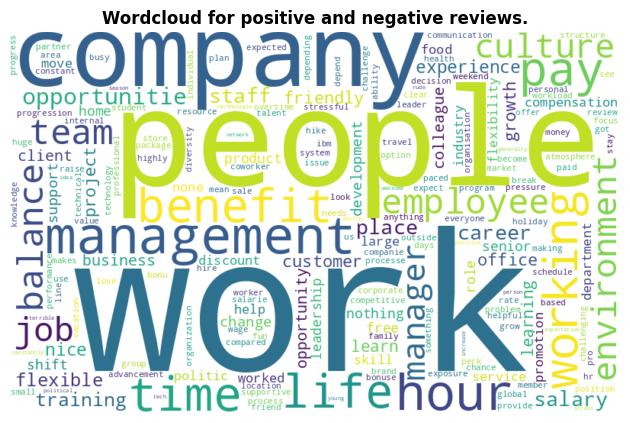

In [11]:
# Now, lets do some wordcloud just to see if we should add some more stopwords.
def plot_wordcloud(df, review_column, title):
    #Juntar todas as frases
    words = ' '.join([word for word in df[review_column]])
    
    # WordCloud
    wordcloud = WordCloud(width = 800, height = 500,
                         collocations = False, background_color = "white").generate(words)
    plt.figure()
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()

plot_wordcloud(df, 'review_without_stopwords', 'Wordcloud for positive and negative reviews.')

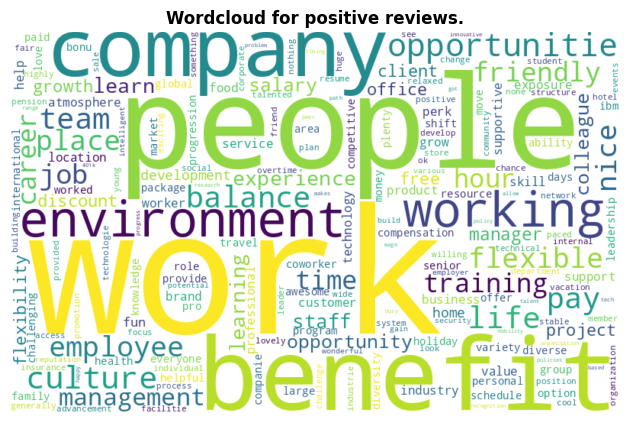

In [12]:
plot_wordcloud(df[np.in1d(df.target, '1')], 'review_without_stopwords', 'Wordcloud for positive reviews.')

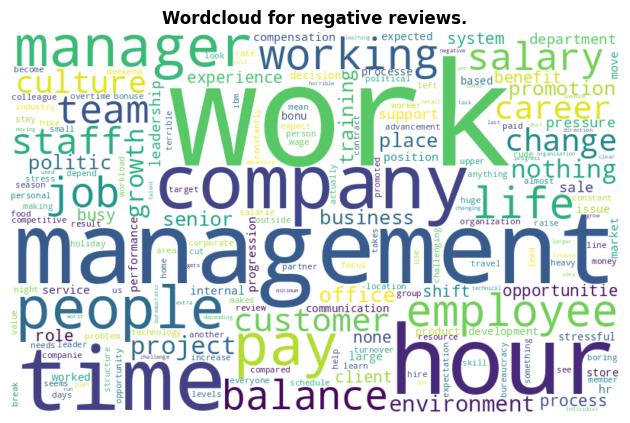

In [13]:
plot_wordcloud(df[np.in1d(df.target, '0')], 'review_without_stopwords', 'Wordcloud for negative reviews.')

In [14]:
# Verify again the proportion of positive and negative reviews.
df_target = pd.DataFrame(df.target.value_counts())
df_target.columns = ['count']
df_target['proportion'] = df_target['count'] / df_target['count'].sum()
df_target

,count,proportion
target,,
1,838553,0.500039
0,838421,0.499961


In [15]:
# Save dataframe
df.to_csv('df_sentiment_analysis_topic_modeling.csv', index = False)
df.head()

,firm,review,target,n_words,review_lower,review_without_stopwords
0,179,I can not think of any,0,6,i can not think of any,
1,174,little advancement based on owners pretty cheap,0,9,little advancement based on owners pretty cheap,advancement based owners cheap
2,47,Low career advancement opportunity and politics,0,6,low career advancement opportunity and politics,career advancement opportunity politics
3,199,The peolpe. Everone that I worked with was fr...,1,12,the peolpe everone that i worked with was fr...,peolpe everone worked friendly helpful
4,229,Dealing with angry customers and putting up wi...,0,20,dealing with angry customers and putting up wi...,dealing angry customers putting ridiculous beh...
